# Parsing of Internal and External Causes of Errors (PIECE) Model 
---

## Generative Model

\begin{align}
p(C = 1) &= 0.5 \\
p(C = 2) &= 0.5 \\
p(x_h | C = 1) &= N(0, \sigma_m^2) \\
p(x_h | C = 2) &= N(0, \sigma_m^2) \\
p(r | C = 2) &= N(0, \sigma_{\text{pert}}^2) \\
p(x_v | x_h, r) &= N(x_h + r, \sigma_v^2) \\
p(x_p | x_h) &= N(x_h, \sigma_p^2) \\
p(x_u | x_h) &= N(x_h, \sigma_u^2) 
\end{align}

- $C$ stands for Cause. We can think of it as a categorical variable: $C=1$ means there is no rotation (perturbation), while $C=2$ indicates a rotation. The observer has a flat prior on $C$.
- $x_h$ refers to the hand position, or hand trajectory. This model assumes the probability distribution is the same whether the reach is perturbed or not; also, the model assumes the observer has knowledge regarding the distribution of their internally-generated errors (IGE), or, motor noise.
- $r$ is the perturbation. The observer has a stronger prior on small perturbations versus larger ones. 

There are 3 cues about the location of reach endpoint:
- $\hat{x}_v$, visual feedback
- $\hat{x}_p$, proprioceptively sensed hand location
- $\hat{x}_u$, efference copy prediction-based cue

## Inference

### Inference of top-level causal node $C$, i.e., whether there is a perturbation or not.  

\begin{align}
p(C=\text{rotation}|x_v, x_p, x_u) &\propto p(x_v, x_p, x_u|C)p(C) \\
&= \iint p(C)p(x_h|C)p(r|C)p(x_v|x_h, r)p(x_p|x_h)p(x_u|x_h)dr dx_h \\
&= p(C) \iint p(x_h|C)p(r|C)p(x_v|x_h, r)p(x_p|x_h)p(x_u|x_h)dr dx_h \\
p(C=\text{no rotation}|x_v, x_p, x_u) &\propto p(x_v, x_p, x_u|C)p(C) \\
\end{align}

There is an analytical solution for the single integral of the product of Gaussians. Kording et al (2007) make use of it, and the derivation comes (indirectly) from Bromiley 2014, where he derives the product of $N$ univariate Gaussians. Specifically, the general expression for the scaling factor in Eqn. 6 (Bromiley) is what we need to compute the likelihood of $C = \text{no rotation}$.

\begin{align}
p(x_v, x_p, x_u|C=\text{no rotation}) &= \int p(x_v|x_h)p(x_p|x_h)p(x_u|x_h)dx_h \\
&= \dfrac{1}{(2\pi)^{(n-1)/2}} \sqrt{\dfrac{\frac{1}{J_v + J_p + J_u}}{\sigma_v^2 \cdot \sigma_p^2 \cdot \sigma_u^2}} \exp \left[-\dfrac{1}{2} \left(\sum\dfrac{\mu_i^2}{\sigma_i^2} - \dfrac{\mu_{i=1...n}^2}{\sigma_{i=1...n}^2}\right) \right] \\
\end{align}

As section 10.3 of the Bayesian modeling textbook points out, it's sometimes hard to gain an intuition about these models from these complicated equations alone. This is when it becomes useful to create visualizations. Based on the textbook, some ideas would include:
- Heat map of posterior on Cause given the measurements
- Measurement distribution when stimuli are held at some level (response probabilities)
- Posterior on Cause as a function of stimulus disparity

### Inference of rotation size

**One possibility:**
\begin{align}
p(r|x_v) &\propto p(x_v|r)p(r) \\
&= p(r) \int p(x_v|x_h, r)p(r|C)p(x_h|C)dx_h, \text{where} \\
p(r) &= \sum_C p(r|C)p(C), \text{but since $r$ is only present when $C=2$, $p(r)=p(r|C)$ and the posterior over $r$ is expressed as follows:} \\
&= p(r) \int p(x_h|C)p(x_v|x_h, r)dx_h \\
\end{align}

**Alternative: Use state estimation (Kalman filtering)**

---
## Simulations

### Technical Issues and Next Steps:
- Takes way too long to run - do I need to vectorize code? If so, what's a good model of that--Hudson model selection tutorial? 
- Other strategies to speed up computations:
    - To compute $p(C|\vec{x})$, seems like you should be able to compute very quickly using closed-form solutions for integrals of Gaussians (see Kording et al 2007, equations 1-6). Perhaps take product of Gaussians and then calculate integral.
    - For stimulus estimates, looks like you can compute estimates directly without computing full posterior (see Kording et al 2007, equations 7-10)
- Incorporate un-normalized values (i.e., ones that are not a proportion of normalized motor noise, $\sigma_f$.

### Conceptual Issues/Questions:
- What does PIECE predict regarding adaptation to consistent perturbation (e.g., $30^{\circ}$ rotation)?
- Shift in proprioception or perceived hand position? Need to infer hand position. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import integrate
from scipy.stats import norm
from scipy.special import logsumexp
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set some defaults
plt.rc("axes.spines", top=False, right=False)

sns.set_theme(context="paper", font_scale=1.2)
sns.set_style("ticks")

%config InlineBackend.figure_format = "retina"

In [2]:
def calc_prob_gauss(x, mu, sigma, bin_width=0.1):
    prob = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    prob = prob * bin_width
    return prob


# Compute the integral of a product of gaussians analytically
def integral_prod_gauss(*params):
    '''
    Input comes in the form of list of lists.
    '''
    
    mus = np.array(params[0])
    sigmas = np.array(params[1])

    n = len(sigmas)
    sum_precisions = np.sum(1 / sigmas**2)
    sigma_prod = np.sqrt(1 / sum_precisions)
    mu_prod = np.sum(mus / sigmas**2) * sigma_prod**2
    scale_factor = (
        1 / ((2 * np.pi)**((n - 1) / 2)) * np.sqrt(sigma_prod**2 / np.prod(sigmas**2)) 
        * np.exp(-1 / 2 * (np.sum(mus**2 / sigmas**2) - mu_prod**2 / sigma_prod**2))
    )
        
    return scale_factor

# Function for computing Gaussian log-probabilities
f = lambda x, mu, sigma: -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * (x - mu)**2 / sigma**2

In [3]:
# Simulated parameters
full_range = 0
if full_range==1:
    pert_size = np.array([-64, -16, -4, 0, 4, 16, 64])
else:
    pert_size = np.array([ -4, -2, 0, 2, 4])
n_per_pert = 100
n_per_miniblock = 2
num_trials = len(pert_size) * n_per_pert * n_per_miniblock + 1  # add 1 to get even number of adaptation measures
perts = np.repeat(pert_size, n_per_pert)
perts = np.random.permutation(perts)
pert_idx = np.arange(1, num_trials, n_per_miniblock)
prepert_idx = pert_idx - 1
postpert_idx = pert_idx + 1

delta_x = np.zeros(num_trials)
delta_x[pert_idx] = perts

# Test different fb schedules; names wrt which trials have vis fb
vis_fb_scheds = ["all", "pre pert", "post pert", "none", "mixed"]
vis_fb_sched = "mixed"
vis_fb = np.zeros(num_trials, dtype=bool)
if vis_fb_sched == "all":
    vis_fb = np.ones(num_trials, dtype=bool)
elif vis_fb_sched == "post pert":
    idx = np.sort(np.concatenate((pert_idx, postpert_idx)))
    vis_fb[idx] = 1
elif vis_fb_sched == "none":
    vis_fb[pert_idx] = 1
elif vis_fb_sched == "mixed":
    vis_fb = np.ones(num_trials, dtype="bool")
    idx = np.sort(np.random.choice(prepert_idx, size=int(len(prepert_idx) / 2), replace=False))
    vis_fb[idx] = 0
elif vis_fb_sched == "pre pert":
    idx = np.sort(np.concatenate((pert_idx, prepert_idx)))
    vis_fb[idx] = 1

# Model parameters. Following values generate slightly negative slope for ige when errors are between -4 and +4:
# sigma_u = 0.2; sigma_p = 2; sigma_f = 2.25; sigma_pert = 8.0; sigma_v = 0.3 + 0.3 * np.abs(xhat_v)
# Following values approximate behavior:
# sigma_u = 0.175; sigma_p = 4.75; sigma_f = 1.8; sigma_pert = 4.25; sigma_v = 1.179 + 0.384 * np.abs(xhat_v)
# sigma_u = 0.12
# sigma_p = 4.5
# sigma_f = 1.8 
# mu_pert = 0
# sigma_pert = 5
# b = 1  # Subject's motor bias

sigma_u = 0.05
sigma_p = 5
sigma_f = 1.44
mu_pert = 0
sigma_pert = 2.5
b = 0  # Subject's motor bias

x_grid = np.arange(-10, 10, 0.1)  # Possible endpoint locations


In [4]:
%%time
# Simulate data
# np.random.seed(777)
random = 0
eps = np.random.normal(loc=0, scale=sigma_f, size=num_trials)  # motor noise

# For vectorized code
x_fs = x_grid.reshape((len(x_grid), 1))  # possible finger endpoint locations (col vec)
d_xvs = x_grid.reshape((1, len(x_grid)))  # possible rotation sizes (row vec)
x_vs = x_grid  # possible locations of visual cues
x_ps = x_grid  # possible locations of proprioceptive cues
x_us = x_grid  # possible locations of predictive cues

# Ideal observer 
likelihood_nopert = []
likelihood_pert = []
decision_pert = []
post_pert = []
loglik_nopert = 0
loglik_pert = 0
loglik_rotation = []
log_post_delta_x = []
rotation_pme = np.zeros(num_trials)
rotation_hat = np.zeros(num_trials)
x_f_pme_nopert = np.zeros(num_trials)
x_f_pme_pert = np.zeros(num_trials)
x_f_hat = np.zeros(num_trials)
x_f = np.zeros(num_trials)
sigma_v = np.zeros(num_trials)
K = np.zeros(num_trials)
like_nopert_analytical = []
prior_pert = 0.5

# Loop through trials
for i in range(num_trials - 1):
    if i==0:
        x_f[i] = eps[i]
    xhat_u = x_f[i]
    xhat_p = x_f[i]
    
    if vis_fb[i] == 0:
        xhat_v = 0
        sigma_v[i] = 1e2
    else:
        xhat_v = x_f[i] + delta_x[i]
        sigma_v[i] = 1.179 + 0.384 * np.abs(xhat_v)  # after Zhang et al 
    J_v = 1 / sigma_v[i]**2
    J_pert = 1 / sigma_pert**2
    K[i] = J_v / (J_v + J_pert)
    
    # Compute no perturbation likelihood (working with log-probs for numerical accuracy)
    loglik_nopert = (
        f(xhat_u, x_fs, sigma_u) + f(xhat_v, x_fs, sigma_v[i]) 
        + f(xhat_p, x_fs, sigma_p) + f(x_fs, b, sigma_f) 
    )
    loglik_nopert = logsumexp(loglik_nopert.flatten(), b=0.1)
    likelihood_nopert.append(np.exp(loglik_nopert))
    
    # Compute the likelihood using closed-form solution to validate other calculation 
    like_nopert_analytical.append(
        integral_prod_gauss(
            *[[xhat_u, xhat_v, xhat_p, b], [sigma_u, sigma_v[i], sigma_p, sigma_f]]
        )
    )

    # Compute perturbation likelihood
    loglik_pert = (
        f(xhat_u, x_fs, sigma_u) + f(xhat_v, x_fs + d_xvs, sigma_v[i]) 
        + f(xhat_p, x_fs, sigma_p) + f(d_xvs, mu_pert, sigma_pert) 
        + f(x_fs, b, sigma_f)  
    )
    loglik_pert = logsumexp(loglik_pert.flatten(), b=0.01)
    # To account for no vis fb trials
    if vis_fb[i] == 1:
        likelihood_pert.append(np.exp(loglik_pert))
    else:
        likelihood_pert.append(0)
    
    # Posterior over Causal node
    normalization_const = prior_pert * likelihood_pert[-1] + ((1 - prior_pert) * likelihood_nopert[-1])
    post_pert.append((prior_pert * likelihood_pert[-1]) / normalization_const)  # posterior on Cause
    decision_pert.append((1 - post_pert[-1]) < post_pert[-1])
    
    # Posterior over rotation size - first compute likelihood
    loglik_rotation = f(x_fs, b, sigma_f) + f(xhat_v, x_fs + d_xvs, sigma_v[i])   
    loglik_rotation = logsumexp(loglik_rotation, axis=0)  # marginalize over hand location
    log_post_rotation = logsumexp(
        f(d_xvs, 0, sigma_pert) 
        + loglik_rotation.reshape((1, -1)), 
        axis=0, 
        b=0.01
    )  # reshaping log-likelihood into row vector 
    
    if vis_fb[i] == 1:
        rotation_pme[i] = x_grid[np.argmax(np.exp(log_post_rotation.flatten()))]
        rotation_hat[i] = post_pert[i] * rotation_pme[i]
    else:
        rotation_pme[i] = 0
        rotation_hat[i] = 0
    
    # Posterior over hand position - need to compute this for perturbed and unperturbed world states!
    log_post_x_f_nopert = (
        f(x_fs, b, sigma_f) + f(x_fs, xhat_u, sigma_u) 
        + f(x_fs, xhat_p, sigma_p) + f(xhat_v, x_fs, sigma_v[i])
    )
    log_post_x_f_pert = (
        (f(x_fs, b, sigma_f) + f(x_fs, xhat_u, sigma_u) + f(x_fs, xhat_p, sigma_p)).flatten()
        + logsumexp(f(xhat_v, x_fs + d_xvs, sigma_v[i]) + f(d_xvs, mu_pert, sigma_pert), axis=1, b=0.1)
    )
    x_f_pme_nopert[i] = x_grid[np.argmax(np.exp(log_post_x_f_nopert.flatten()))]
    x_f_pme_pert[i] = x_grid[np.argmax(np.exp(log_post_x_f_pert.flatten()))]
    x_f_hat[i] = post_pert[-1] * x_f_pme_pert[i] + (1 - post_pert[-1]) * x_f_pme_nopert[i]
    
    # Simulate trial-by-trial adaptation
    # x_f[i + 1] = rotation_hat[i]*-1 + eps[i + 1]
    # x_f[i + 1] = post_pert[i] * K[i] * (xhat_v - x_f_hat[i]) * -1 + eps[i + 1]
    x_f[i + 1] = post_pert[i] * K[i] * (delta_x[i]) * -1 + eps[i + 1]


# Append values to final trial to keep arrays same size - has no effect on
# analysis bc these trials get trimmed from adaptation data frame
decision_pert.append(False)
post_pert.append(0)  


CPU times: user 1.14 s, sys: 2.08 ms, total: 1.14 s
Wall time: 1.14 s


In [5]:
# adaptation quantified as difference in hand angle post- and pre-perturbation
adaptation = np.zeros(num_trials)
adaptation[1::n_per_miniblock] = x_f[2::n_per_miniblock] - x_f[0:-1:n_per_miniblock]

# Create data frame with all trials
df = pd.DataFrame({
    "x_f":x_f, "delta_x":delta_x, "K":K, "sigma_v":sigma_v, "post_pert":post_pert, "rotation_pme":np.round(rotation_pme, 2), 
    "rotation_hat":np.round(rotation_hat, 2), "adaptation":adaptation, "decision_pert":decision_pert,
    "x_f_hat":x_f_hat, "percept_shift":x_f_hat - x_f, "x_f_pme_nopert":x_f_pme_nopert, 
    "x_f_pme_pert": x_f_pme_pert
})
df.head(5)

,x_f,delta_x,K,sigma_v,post_pert,rotation_pme,rotation_hat,adaptation,decision_pert,x_f_hat,percept_shift,x_f_pme_nopert,x_f_pme_pert
0,0.584075,0.0,0.000625,100.000000,0.000000,0.0,0.00,0.000000,False,0.6,0.015925,0.6,0.6
1,-1.216054,0.0,0.697607,1.645965,0.354866,-0.7,-0.25,-1.327081,False,-1.2,0.016054,-1.2,-1.2
2,-0.743006,0.0,0.744560,1.464314,0.335838,-0.4,-0.13,0.000000,False,-0.7,0.043006,-0.7,-0.7
3,-1.514182,2.0,0.770204,1.365554,0.521794,0.3,0.16,-0.478930,True,-1.5,0.014182,-1.5,-1.5
4,-1.221936,0.0,0.697028,1.648223,0.355088,-0.7,-0.25,0.000000,False,-1.2,0.021936,-1.2,-1.2


In [6]:
# Create trimmed data frame without null trials
df_adapt = df.iloc[1::2].reset_index()

In [7]:
# Group by perturbation level
df_adapt.groupby("delta_x")[["post_pert", "adaptation"]].mean().reset_index()

,delta_x,post_pert,adaptation
0,-4.0,0.576050,1.481663
1,-2.0,0.474669,0.515870
2,0.0,0.348854,-0.150319
3,2.0,0.479496,-1.084263
4,4.0,0.586522,-0.758347


In [8]:
# Determine proportion of decision on perturbation
df.groupby("delta_x")["decision_pert"].apply(lambda x: float(x.sum()) / x.count()).reset_index()

,delta_x,decision_pert
0,-4.0,0.93
1,-2.0,0.17
2,0.0,0.00
3,2.0,0.21
4,4.0,0.92


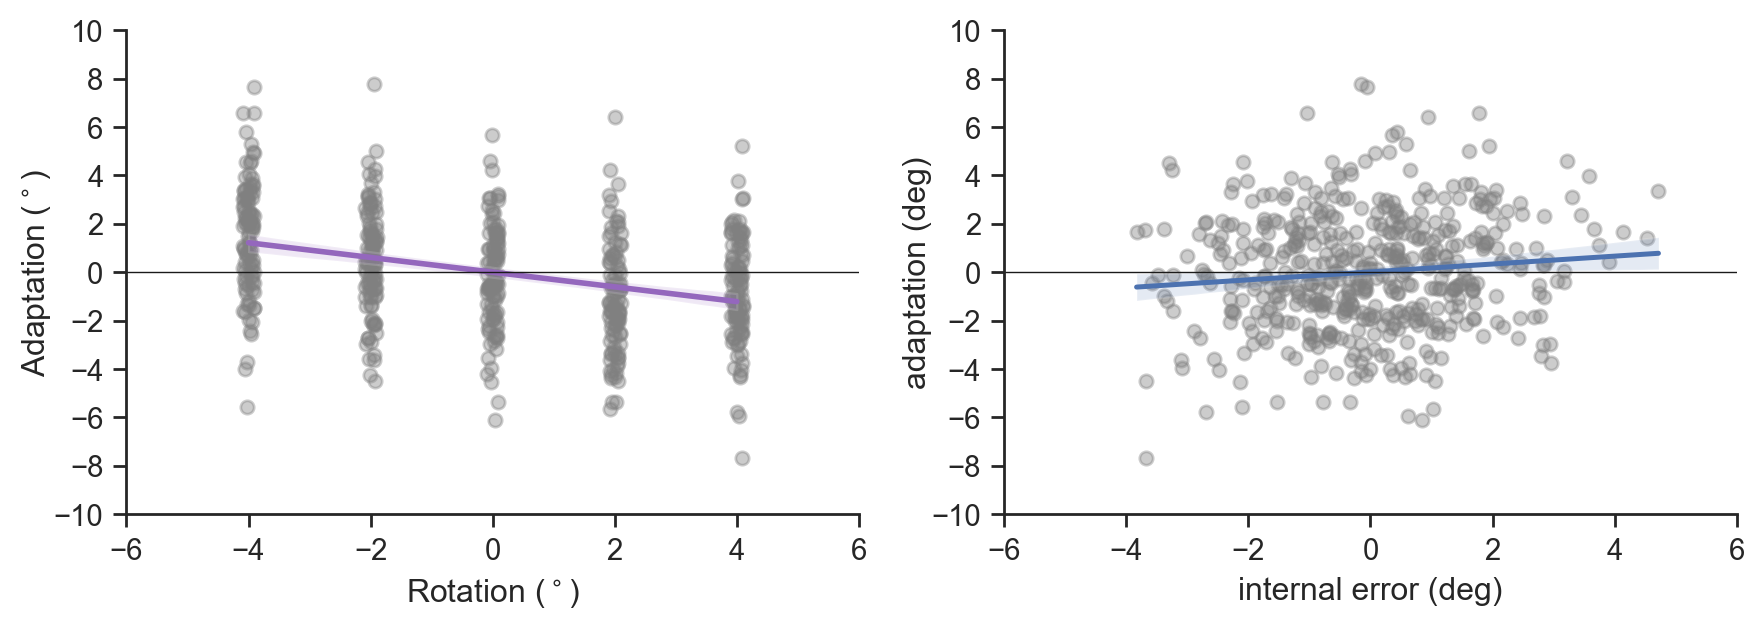

In [9]:
# State estimator (visual learner)
fig, axs = plt.subplots(1, 2, figsize=(9, 3.33))
sns.despine()
if full_range == 1:
    sns.regplot(data=df_adapt, x="delta_x", x_jitter=0.1, y="adaptation", 
                lowess=True, scatter_kws={"alpha":0.4, "color":"gray"},  
                line_kws={"color":"tab:purple", "linewidth":2}, ax=axs[0])
    axs[0].set(xlabel="Rotation ($^\circ$)", ylabel="Adaptation ($^\circ$)",
               xticks=np.arange(-64, 64.01, 16), title="PIECE Model Simulation")
else:
    sns.regplot(data=df_adapt, x="delta_x", x_jitter=0.1, y="adaptation", 
                scatter_kws={"alpha":0.4, "color":"gray"},  
                line_kws={"color":"tab:purple", "linewidth":2}, ax=axs[0])
    axs[0].set(xlabel="Rotation ($^\circ$)", ylabel="Adaptation ($^\circ$)", 
               xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), ylim=[-10, 10], 
               yticks=np.arange(-10, 10.01, 2))
axs[0].yaxis.labelpad = 0
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=df_adapt, x="x_f", y="adaptation", line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
axs[1].set(xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
axs[1].axhline(color="k", linewidth=0.5)
axs[1].yaxis.labelpad = 0

plt.tight_layout()
# fig.savefig("images/piece-model-sim.png", dpi=300)



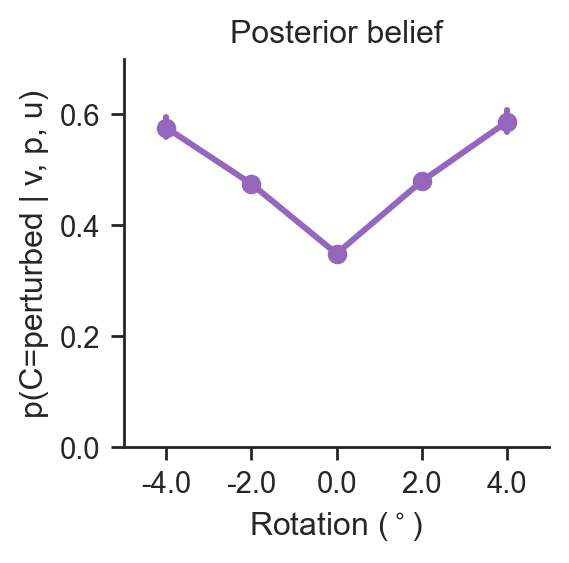

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.despine()
sns.pointplot(data=df_adapt, x="delta_x", y="post_pert", color="tab:purple", 
              legend=False, label="Posterior", ax=ax)
# sns.pointplot(data=df_adapt, x="delta_x", y="K", label="K", ax=ax)
# sns.pointplot(data=df_adapt, x="delta_x", y="sigma_v", label="$\sigma_v$", ax=ax)
ax.set(xlabel="Rotation ($^\circ$)", ylabel="p(C=perturbed | v, p, u)",
       ylim=(0, 0.7), title="Posterior belief")
plt.tight_layout()
# fig.savefig("images/posterior-piece.png", dpi=300)


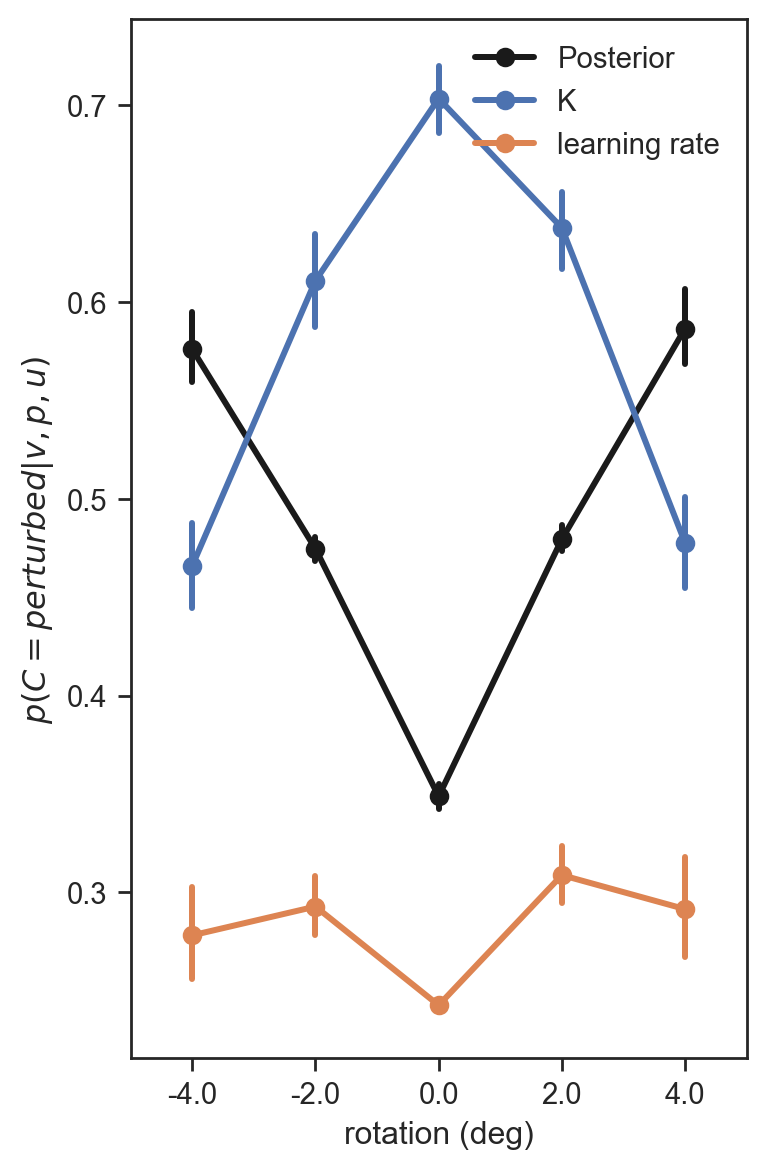

In [11]:
df_adapt["learning_rate"] = df_adapt["post_pert"] * df_adapt["K"]

fig, ax = plt.subplots(figsize=(4, 6))
sns.pointplot(data=df_adapt, x="delta_x", y="post_pert", color="k", label="Posterior", ax=ax)
sns.pointplot(data=df_adapt, x="delta_x", y="K", label="K", ax=ax)
sns.pointplot(data=df_adapt, x="delta_x", y="learning_rate", label="learning rate", ax=ax)
ax.set(xlabel="rotation (deg)", ylabel="$p(C=perturbed | v, p, u)$")
ax.legend(frameon=False)
plt.tight_layout()
# fig.savefig("posterior-piece.png")

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


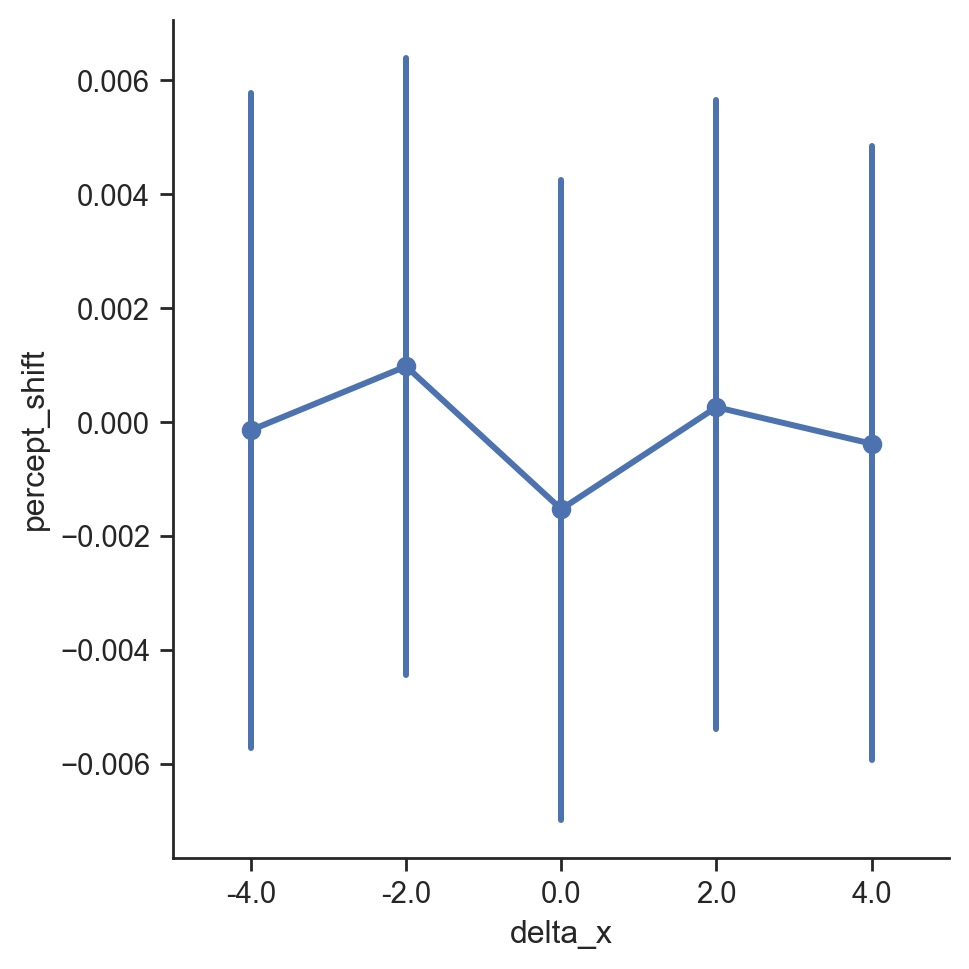

In [12]:
sns.catplot(data=df_adapt, kind="point", x="delta_x", y="percept_shift")
plt.show()

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


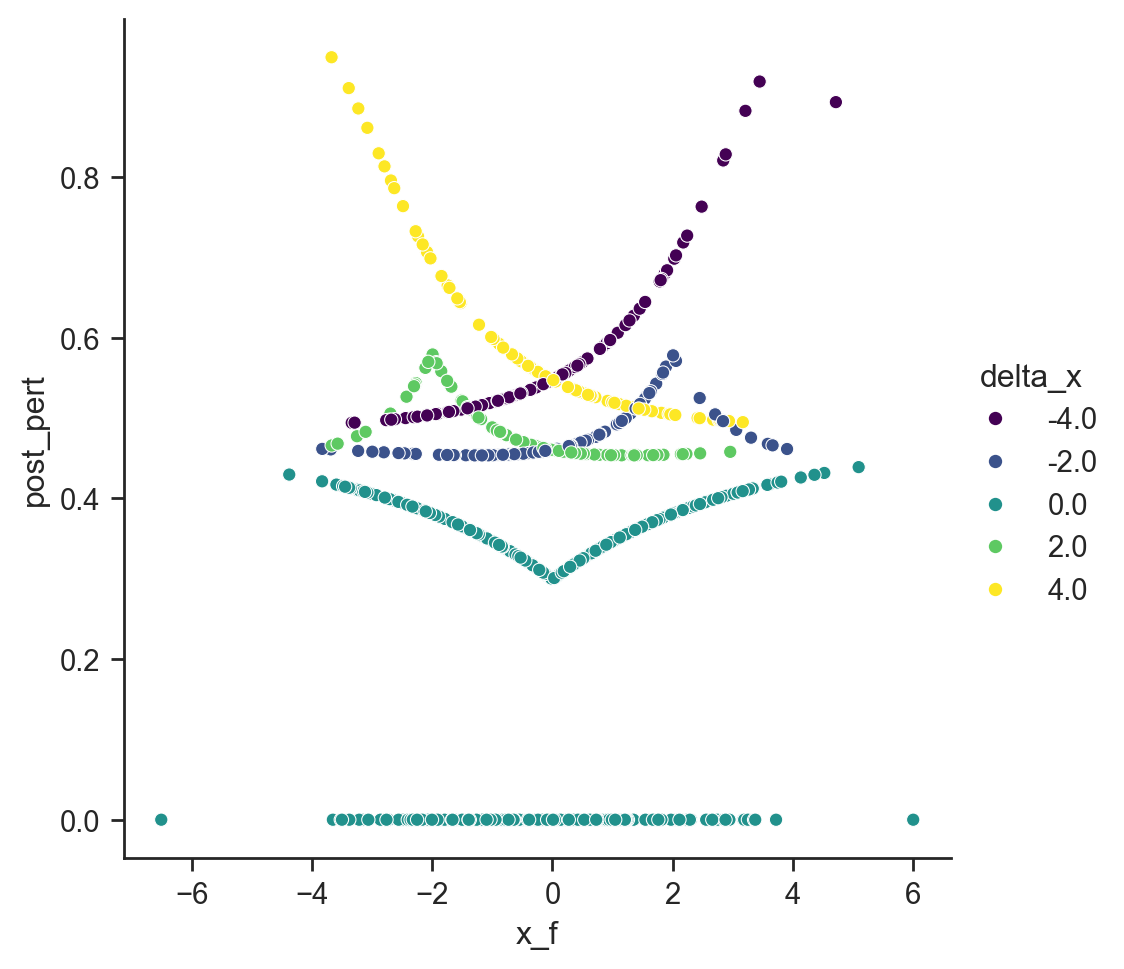

In [13]:
sns.relplot(data=df, x="x_f", y="post_pert", hue="delta_x", palette="viridis")
plt.show()

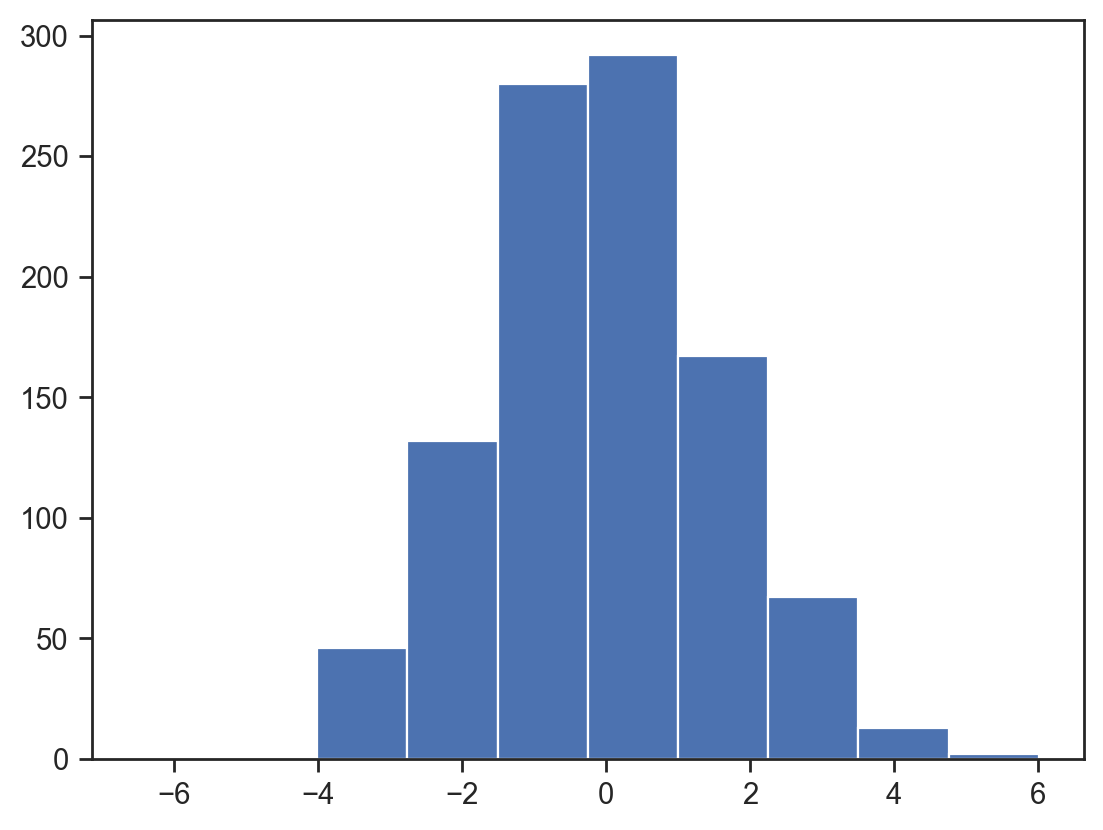

1.6241865521961354


In [14]:
plt.hist(x_f)
plt.show()

print(x_f.std())